# Sarcastic Headline Detection w/ BERT

### Problem

In this noteook, I will be predicting if a news headline is sarcasm. This News Headlines dataset for Sarcasm Detection is collected from two news website.   
**_The Onion_**, which aims at producing sarcastic versions of current events.   
**_The Huffington Post_**, which is a real (non-sarcastic) news outlet.  

### Context

- `is_sarcastic`: 1 if the headline is sarcastic, otherwise 0
- `headline`: The headline of the news article
- `article_link`: The link to the original news article

### Models

This problem is a binary classification problem where I will be using two models. A baseline of **Naive Bayes** and a more advanced **Deep Neural Network (DNN)** design using **BERT** as a base layer with multiple convolutional and dense layers to predict the sarcastic headlines.

For implementing **BERT**, I will be fine-tunning BERT by freezing it's trainable layers and only training the additional layers underneath.

*Note: The results from the DNN were trained on two tesla V100 32GB GPU's*

### Measure of success

For this problem, I will define the measure of success by using *accuracy* because the dataset contains almost equal numbers of each predictors.

**Number of binary labels**  
Not Sarcastic: 29,970  
Sarcastic: 25,358

Dataset Link: https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection

**Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import os
from datetime import datetime
import tensorflow as tf
import tensorflow_hub as hub
from keras.utils import np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import official.nlp.bert.tokenization as tokenization
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')

Enable GPU growth

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [3]:
import os
data_dir = './data/Sarcastic Headlines/'
os.path.exists(data_dir)

True

In [4]:
raw_data_1 = pd.read_json(path_or_buf=data_dir + 'Sarcasm_Headlines_Dataset.json', lines=True)
raw_data_2 = pd.read_json(path_or_buf=data_dir + 'Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [5]:
raw_data_1.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
raw_data_2.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [7]:
print('Dataset 1 has {} columns and {} rows'.format(raw_data_1.shape[0], raw_data_1.shape[1]))
print('Dataset 2 has {} columns and {} rows'.format(raw_data_2.shape[0], raw_data_2.shape[1]))

Dataset 1 has 26709 columns and 3 rows
Dataset 2 has 28619 columns and 3 rows


Join both together

In [8]:
complete_data_raw = pd.concat([raw_data_1, raw_data_2]).reset_index(drop=True).copy()

In [9]:
complete_data_raw.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [10]:
complete_data_raw.shape

(55328, 3)

There are 55,328 total rows in the dataset

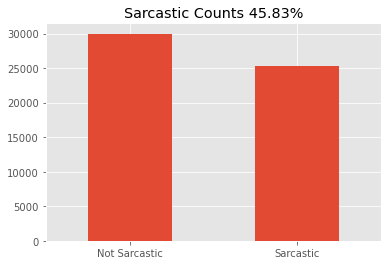

In [11]:
num_sarcastic = complete_data_raw['is_sarcastic'].value_counts()[1]
num_not_sarcastic = complete_data_raw['is_sarcastic'].value_counts()[0]

complete_data_raw['is_sarcastic'].value_counts().plot(kind='bar')
plt.xticks([0,1], ['Not Sarcastic', 'Sarcastic'], rotation=0)
plt.title('Sarcastic Counts {:.2f}%'.format((num_sarcastic / (num_sarcastic + num_not_sarcastic)*100)));

Overall, this dataset is fairly balanced

**Pre-processing**

For pre-processing the data, I will only be removing the punctuations and capitalizations in order to preserve as much of the original headlines as possible

In [12]:
# Copy the original data
complete_data_preprocessed = complete_data_raw.copy()

# Lowercases all words
complete_data_preprocessed['headline'] = complete_data_preprocessed['headline'].str.lower()

# Remove all puncutation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

complete_data_preprocessed['headline'] = complete_data_preprocessed['headline'].apply(remove_punctuations)

In [13]:
complete_data_preprocessed.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret bl...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the roseanne revival catches up to our thorny ...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear sons web series closest t...,1
3,https://politics.theonion.com/boehner-just-wan...,boehner just wants wife to listen not come up ...,1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,jk rowling wishes snape happy birthday in the ...,0


**Checking for duplicates**

In [14]:
complete_data_preprocessed[complete_data_preprocessed.duplicated()].shape

(26711, 3)

There are 26,711 duplicate entries in the dataset. YIKES!  
I will remove those.

In [15]:
complete_data_preprocessed.drop_duplicates(inplace=True)
complete_data_preprocessed.shape

(28617, 3)

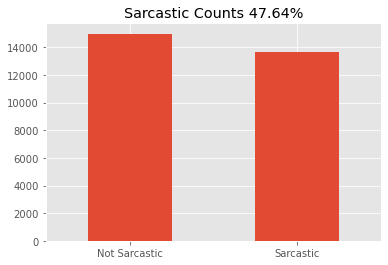

In [16]:
num_sarcastic = complete_data_preprocessed['is_sarcastic'].value_counts()[1]
num_not_sarcastic = complete_data_preprocessed['is_sarcastic'].value_counts()[0]

complete_data_preprocessed['is_sarcastic'].value_counts().plot(kind='bar')
plt.xticks([0,1], ['Not Sarcastic', 'Sarcastic'], rotation=0)
plt.title('Sarcastic Counts {:.2f}%'.format((num_sarcastic / (num_sarcastic + num_not_sarcastic)*100)));

Now that the data does not contain duplicates and is pre-processed, I will first begin with a baseline Naive Bayes model.

**Creating a dataset with stopwords removed**

In [17]:
standford_stopwords = {"'ll", "'m", "'s", 'a', 'about', 'above', 'after', 'again', 'against', 'ah', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'arent', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', "can't", 'cannot', 'cant', 'could', "couldn't", 'couldnt', 'did', "didn't", 'didnt', 'do', 'does', "doesn't", 'doesnt', 'doing', "don't", 'dont', 'down', 'during', 'each', 'er', 'er', 'few', 'for', 'from', 'further', 'had', "hadn't", 'hadnt', 'has', "hasn't", 'hasnt', 'have', "haven't", 'havent', 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'heres', 'hers', 'herself', 'hes', 'him', 'himself', 'his', 'how', "how's", 'hows', 'i', "i'd", "i'll", "i'm", "i've", 'if', 'im', 'in', 'into', 'is', "isn't", 'isnt', 'it', "it's", 'its', 'itself', "let's", 'lets', 'like', 'me', 'more', 'most', "mustn't", 'mustnt', 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'oh', 'okay', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours ', 'ourselves', 'out', 'over', 'own', 'return', 'right', 'same', "shan't", 'shant', 'she', "she'd", "she'll", "she's", 'shes', 'should', "shouldn't", 'shouldnt', 'so', 'some', 'such', 'than', 'that', "that's", 'thats', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', "there's", 'theres', 'these', 'they', "they'd", "they'll", "they're", "they've", 'theyll', 'theyre', 'theyve', 'this', 'those', 'through', 'to', 'too', 'uh', 'um', 'under', 'until', 'up', 'very', 'was', "wasn't", 'wasnt', 'we', "we'd", "we'll", "we're", "we've", 'well', 'were', "weren't", 'werent', 'what', "what's", 'whats', 'when', "when's", 'whens', 'where', "where's", 'wheres', 'which', 'while', 'who', "who's", 'whom', 'whos', 'why', "why's", 'whys', 'with', "won't", 'wont', 'would', "wouldn't", 'wouldnt', 'yeah', 'you', 'you know', "you'd", "you'll", "you're", "you've", 'youd', 'youll', 'your', 'youre', 'yours', 'yourself', 'yourselves', 'youve'}

In [18]:
def remove_stopwords(tokens: list(), stop_words: set(), replace: str = None) -> list():
    filtered = []
    ### Removing stop words
    for word in tokens:
        if word not in stop_words:
            filtered.append(word)
        else:
            if replace is not None:
                filtered.append(replace)
    return filtered

In [19]:
def clean_response(row):
    response_list = row.split()
    response_list_cleaned = remove_stopwords(response_list, standford_stopwords)
    return ' '.join(response_list_cleaned)

In [20]:
complete_data_preprocessed['headline'][2]

'mom starting to fear sons web series closest thing she will have to grandchild'

In [21]:
clean_response(complete_data_preprocessed['headline'][2])

'mom starting fear sons web series closest thing will grandchild'

Apply to whole dataset

In [22]:
complete_data_preprocessed['headline_no_stopwords'] = complete_data_preprocessed['headline'].apply(clean_response)
complete_data_preprocessed

,article_link,headline,is_sarcastic,headline_no_stopwords
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret bl...,0,former versace store clerk sues secret black c...
1,https://www.huffingtonpost.com/entry/roseanne-...,the roseanne revival catches up to our thorny ...,0,roseanne revival catches thorny political mood...
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear sons web series closest t...,1,mom starting fear sons web series closest thin...
3,https://politics.theonion.com/boehner-just-wan...,boehner just wants wife to listen not come up ...,1,boehner just wants wife listen come alternativ...
4,https://www.huffingtonpost.com/entry/jk-rowlin...,jk rowling wishes snape happy birthday in the ...,0,jk rowling wishes snape happy birthday magical...
...,...,...,...,...
55206,https://www.theonion.com/tyson-holds-contest-t...,tyson holds contest to let fans submit new ide...,1,tyson holds contest let fans submit new ideas ...
55218,https://politics.theonion.com/increasingly-coc...,increasingly cocky bernie sanders announces he...,1,increasingly cocky bernie sanders announces ta...
55229,https://www.theonion.com/cash-strapped-zuckerb...,cashstrapped zuckerberg forced to sell 11 mill...,1,cashstrapped zuckerberg forced sell 11 million...
55253,https://local.theonion.com/grocery-store-bar-a...,grocery store bar actually has great little ha...,1,grocery store bar actually great little happy ...


**Data Exploration**

*Counting how many unique words there are in the dataset*

In [27]:
all_entries = ''
for i in range(complete_data_preprocessed.shape[0]):
    try:
        all_entries += str(complete_data_preprocessed['headline'][i]) + ' '
    except:
        continue

all_entries = all_entries.split()
total_words = len(np.unique(np.array(all_entries)))
print('There are {} total words in the dataset'.format(total_words))

There are 28523 total words in the dataset


### Naive Bayes (Baseline)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

**Split dataset into training and testing data**

In [24]:
X = complete_data_preprocessed['headline']
y = complete_data_preprocessed['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, # 20% for testing, 80% for training 
                                                    random_state=43) # Initializing for reproducibility

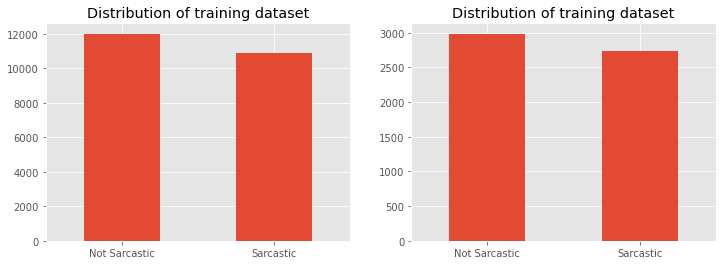

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

y_train.value_counts().plot.bar(ax=ax1)
plt.sca(ax1)
plt.title('Distribution of training dataset')
plt.xticks([0,1],['Not Sarcastic','Sarcastic'], rotation=0)

y_test.value_counts().plot.bar(ax=ax2)
plt.sca(ax2)
plt.title('Distribution of training dataset')
plt.xticks([0,1],['Not Sarcastic','Sarcastic'], rotation=0);

In [28]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train, y_train)

### Make predictions
y_predict = model.predict(X_test)

In [29]:
print('Baseline Accuracy: {:.2f}%'.format((y_test == y_predict).mean() * 100))

Baseline Accuracy: 82.91%


We were able to accurately predict if a headline is sarcastic around 83% of the time. Next, I will be using a much more complex DNN model to improve this accuracy.

### BERT Tensorflow Implementation

**Pre-processing**

1.   Split data into train, validation, and test datasets
2.   Encode labels
3.   Tokenize text

*Removing Duplicates in the dataset*

In [40]:
num_rows_b4 = complete_data_raw.shape[0]
complete_data_raw.drop_duplicates(inplace=True)
num_rows_after = complete_data_raw.shape[0]
print('{} duplicate rows dropped'.format(num_rows_b4 - num_rows_after))
print('New number of rows in data set:', complete_data_raw.shape[0])

26711 duplicate rows dropped
New number of rows in data set: 28617


*Shuffling the dataset*

In [41]:
### Shuffling the dataset
df = complete_data_raw[['headline','is_sarcastic']].sample(frac=1, random_state=42).copy() # Rename dataset
df.head()

,headline,is_sarcastic
44904,christian bale loses 40 years for upcoming mov...,1
1660,jon stewart and 9/11 responders walk the halls...,0
96,inhofe's grand climate conspiracy theory: it's...,0
6237,amber rose fearful over breast reduction surge...,0
6650,23-hour suicide watch a failure,1


*Finding the optimal `input_length` to feed into the DNN*

In [42]:
### Finding the length of the longest headline
def give_length(text):
    return len(text.split())

df['headline_length'] = df['headline'].apply(give_length)
print('Max Headline Length {}'.format(df['headline_length'].max()))
print('Mean Headline Length {:.2f}'.format(df['headline_length'].mean()))
print('Median Headline Length {}'.format(df['headline_length'].median()))
print('Third Quantile Headline Length {}'.format(np.percentile(df['headline_length'], 75)))
print('90% Headline Length {}'.format(np.percentile(df['headline_length'], 90)))
print('99.99% Headline Length {}'.format(np.percentile(df['headline_length'], 99.99)))

Max Headline Length 151
Mean Headline Length 10.05
Median Headline Length 10.0
Third Quantile Headline Length 12.0
90% Headline Length 14.0
99.99% Headline Length 31.96879999997327


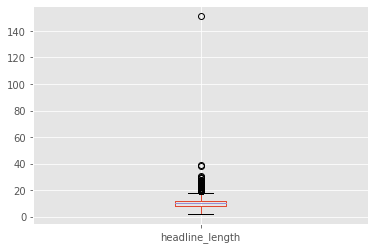

In [43]:
df['headline_length'].astype(float).plot.box();

**Creating our test, training, validation datasets**

- Training (~70%)
- Validation (~20%)
- Testing (~10%)

In [44]:
num_samples = df.shape[0]
training_samples = int(np.percentile(np.arange(num_samples), 70))
validation_samples = int(np.percentile(np.arange(num_samples), 20))
print('{} number of samples'.format(num_samples))
print('{} training samples'.format(training_samples))
print('{} validation samples'.format(validation_samples))
print('{} testing samples'.format(num_samples - training_samples - validation_samples))

28617 number of samples
20031 training samples
5723 validation samples
2863 testing samples


In [45]:
data = df['headline']
labels = df['is_sarcastic']

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
x_test = data[training_samples + validation_samples:]
y_test = labels[training_samples + validation_samples:]

In [46]:
### Sanity Check
assert(x_train.shape[0] == training_samples)
assert(y_train.shape[0] == training_samples)
assert(x_val.shape[0] == validation_samples)
assert(y_val.shape[0] == validation_samples)
assert(x_test.shape[0] == num_samples - training_samples - validation_samples)
assert(y_test.shape[0] == num_samples - training_samples - validation_samples)

**Pre-Processing**

*Turning the tokenization process into functions*

In [48]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2", trainable=False) ### Download BERT

import official.nlp.bert.tokenization as tokenization
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy() 
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()  
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
# 1. vocab_file: reads the vocab file associated to the downloaded model.
# 2. do_lower_case: reads binary variable which if True means tokenizer will reformat all text to lower 
#    case rendering model to be **NOT** case sensitive. Should be False by default. You can check in a cell below.
# 3. tokenizer: builds tokenizer using variables 1 and 2.

def encode_names(n, tokenizer):
    tokens = list(tokenizer.tokenize(n)) ### Tokenizes the string
    tokens.append('[SEP]') ### Add a [SEP] token to the end of each headline
    return tokenizer.convert_tokens_to_ids(tokens) ### Returns an array of Token ID's

def bert_encode(string_list, tokenizer, max_seq_length):
    num_examples = len(string_list)

    ### Encodes all the headlines as token ID's
    string_tokens = tf.ragged.constant([encode_names(n, tokenizer) for n in np.array(string_list)])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0] ### Creates an array of [CLS] token ID's
    input_word_ids = tf.concat([cls, string_tokens], axis=-1) ### Appends it to the front of all the headlines

    input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length)) ### Creating an input mask of 1 and 0's

    ### Create and append a 0 to the beginning of the input mask for the [CLS] token 
    type_cls = tf.zeros_like(cls)
    type_tokens = tf.ones_like(string_tokens)
    input_type_ids = tf.concat([type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

    ### Puts everything into a dict
    inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

    return inputs

*Processing our training, testing, and validation sets*

In [49]:
X_train = bert_encode(x_train, tokenizer, 151)
X_test = bert_encode(x_test, tokenizer, 151)
X_val = bert_encode(x_val, tokenizer, 151)

### BERT architecture

In [111]:
# Dropping out 20% of the embeddings on any given round of training
drop_embed = 0.2

# CNN Layer Architecture
n_conv_1 = n_conv_2 = n_conv_3 = 256

# Filter lengths of 4, 5, and 6 words
k_conv_1 = 4
k_conv_2 = 5
k_conv_3 = 6

# dense layer architecture: 
n_dense = 256
dropout = 0.2

max_seq_length = 151  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

# Spatial Dropout 1D
drop_embed_layer = tf.keras.layers.SpatialDropout1D(drop_embed, name='drop_embed')(sequence_output)

### Three parallel convolutional streams:
conv_1 = tf.keras.layers.Conv1D(filters=n_conv_1, kernel_size=k_conv_1, activation='relu', name='conv_1')(drop_embed_layer)
maxp_1 = tf.keras.layers.GlobalMaxPooling1D(name='maxp_1')(conv_1)

conv_2 = tf.keras.layers.Conv1D(n_conv_2, k_conv_2, activation='relu', name='conv_2')(drop_embed_layer)
maxp_2 = tf.keras.layers.GlobalMaxPooling1D(name='maxp_2')(conv_2)

conv_3 = tf.keras.layers.Conv1D(n_conv_3, k_conv_3, activation='relu', name='conv_3')(drop_embed_layer)
maxp_3 = tf.keras.layers.GlobalMaxPooling1D(name='maxp_3')(conv_3)

### Concatenate the activations from three streams:
concat = tf.keras.layers.concatenate([maxp_1, maxp_2, maxp_3])

dense_layer_1 = tf.keras.layers.Dense(256, activation='relu', name='Dense_1')(concat)
dense_layer_dropout_1 = tf.keras.layers.Dropout(rate=0.2, name='Dense_Dropout_1')(dense_layer_1)

dense_layer_2 = tf.keras.layers.Dense(64, activation='relu', name='Dense_2')(dense_layer_dropout_1)
dense_layer_dropout_2 = tf.keras.layers.Dropout(rate=0.1, name='Dense_Dropout_2')(dense_layer_2)

output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(dense_layer_dropout_2)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

In [112]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 151)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 151)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 151)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=100)

<img src="Sarcasm img.png">

Create a directory with the date

In [113]:
now = datetime.now() # current date and time
year = now.strftime("%Y")
month = now.strftime("%m")
day = now.strftime("%d")
date = month+day+year

### Create an output directory
output_dir = '/scratch/dlilenth/model_output/bert_multi_cased_L-12_H-768_A-12_v2_fixed_convs_'+date
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

Compile the model

In [114]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

**Train!!**

I will be implementing early stopping and reducing learning rates as part of the training process

In [115]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5')

early_stopping = EarlyStopping(patience=3, # Stop after 3 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=False, # Don't Restore the best weights
                               verbose=1) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

history = model.fit(X_train,
                    y_train, 
                    epochs=10,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[modelcheckpoint, early_stopping, reduce_lr],
                    verbose=1)

Epoch 1/10
1252/1252 [==============================] - 102s 80ms/step - loss: 0.5396 - accuracy: 0.7233 - val_loss: 0.3108 - val_accuracy: 0.8677
Epoch 2/10
1252/1252 [==============================] - 99s 79ms/step - loss: 0.2831 - accuracy: 0.8807 - val_loss: 0.2883 - val_accuracy: 0.8794
Epoch 3/10
1252/1252 [==============================] - 99s 79ms/step - loss: 0.2220 - accuracy: 0.9100 - val_loss: 0.2813 - val_accuracy: 0.8897

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/10
1252/1252 [==============================] - 99s 79ms/step - loss: 0.1298 - accuracy: 0.9516 - val_loss: 0.2876 - val_accuracy: 0.8962

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 5/10
1252/1252 [==============================] - 99s 79ms/step - loss: 0.1017 - accuracy: 0.9605 - val_loss: 0.2936 - val_accuracy: 0.8983

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 6/10
1252/1252 [=

In [116]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Training Accuracy: epoch {}".format(np.argmax(val_acc)+1))

Lowest Validation Loss: epoch 3
Highest Training Accuracy: epoch 5


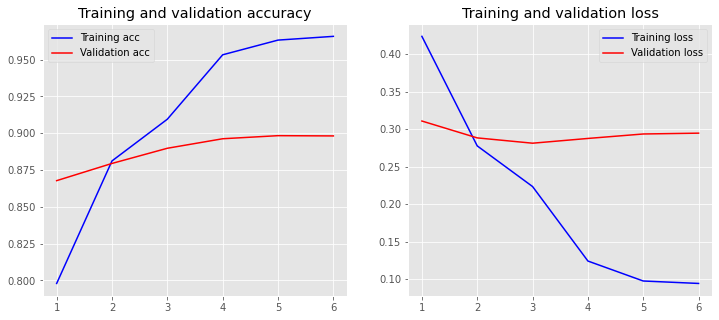

In [117]:
plot_history(history)

**Load in the model with the best validation accuracy**

In [136]:
model.load_weights(output_dir+"/weights.05.hdf5") # Load in model weights

*Evaluate on the test set*

In [137]:
y_test_hat = model.predict(X_test)
y_hat = (y_test_hat > 0.5).astype(int).flatten()

Text(0.5, 1.0, 'Confidence of predictions')

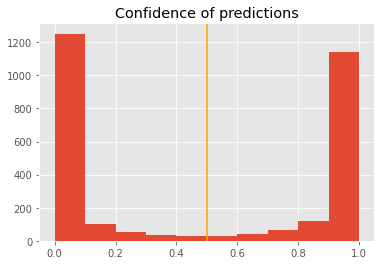

In [163]:
plt.hist(y_test_hat)
_ = plt.axvline(x=0.5, color='orange') ### Fitting the traditional .5 accuracy threshold is
plt.title('Confidence of predictions');

Our model has more *Not Sarcastic* (**0**) predictions than *Sarcastic* (**1**). This is reflective of the dataset containing slightly more *Not Sarcastic* examples. 

In [139]:
print(classification_report(y_test, y_hat, target_names=['Not Sarcastic', 'Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.91      0.89      0.90      1499
    Sarcastic       0.88      0.90      0.89      1364

     accuracy                           0.90      2863
    macro avg       0.90      0.90      0.90      2863
 weighted avg       0.90      0.90      0.90      2863



We achieved a 90% accuracy on the results

*Confusion Matrix*

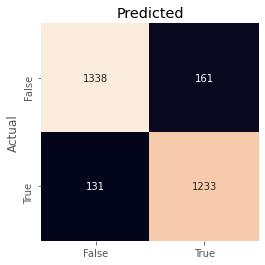

In [140]:
matrix = confusion_matrix(y_test, y_hat)
sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['False','True'], yticklabels=['False','True'])
plt.title('Predicted')
plt.ylabel('Actual');

**Taking a look at which observations we got wrong**

In [141]:
print('There are {} oberservations we guessed incorrectly'.format(x_test[(y_test != y_hat)].shape[0]))

There are 292 oberservations we guessed incorrectly


Observations that were predicted **True** *(y_hat = 1)* but actually **False** *(y_test = 0)*

*Printing the first 10 examples*

In [145]:
[print(example) for example in x_test[(y_test == 0)&(y_hat == 1)][:10]];

astronomers discover most distant galaxy yet
nyc removes statue honoring 19th century surgeon who experimented on female slaves
rnc proclaims mike pence the winner more than an hour before the debate
christianity's hijacked brand
pre-holiday jerry brown preps for term 4
ohio moves to ban abortion after 6 weeks of pregnancy
hillary accuses china of trying to 'hack in everything that doesn't move'
facebook built censorship tool to appease china expansion
dad opens up about the tough conversation sparked by water guns
mom gives excuse for son's absence that even hermione would accept


We can see here that some of the examples the model guessed incorrectly sound like they could actually be a real headline.

*Printing the first 10 examples*

Observations that were predicted **False** *(y_hat = 0)* but actually **True** *(y_test = 1)*

In [146]:
[print(example) for example in x_test[(y_test == 1)&(y_hat == 0)][:10]];

billy joel has billy joel's disease
swiss threaten ricola embargo
senate subcommittee on energy and water development more like a family
pursued drunk driver crafts brilliant 'don't stop' plan
polka fan on a real harold loeffelmacher kick lately
new ed mcmahon autobiography reveals he slept with 7 women
trump accidentally fires off 'boring mike pence' tweet during vp speech before he can stop himself
tiny dog suffocates in louis vuitton bag
trump confirms all violent options on the table in venezuela
hotshot test pilot removes helmet, reveals female status


Some of the examples the model guessed incorrectly here do seem like they could be fake headlines, but are actually real. 

**Create a function to make predictions yourself**

In [156]:
sentence = "Trump, at US-Mexican border, slams Biden for ‘open, really dangerous’ border".lower()
# Pulled from fox news
prediction = model.predict(bert_encode([remove_punctuations(sentence)], tokenizer, 151))
print("Model predicted: {}".format("Sarcastic" if (prediction[0][0] > 0.5).astype(int).flatten() == 1 else "Not Sarcastic"))

Model predicted: Not Sarcastic


In [157]:
sentence = "Frenchwoman who killed abusive husband faints in court as prosecutors seek sentence that could see her walk free".lower()
### Pulled from CNN
prediction = model.predict(bert_encode([remove_punctuations(sentence)], tokenizer, 151))
print("Model predicted: {}".format("Sarcastic" if (prediction[0][0] > 0.5).astype(int).flatten() == 1 else "Not Sarcastic"))

Model predicted: Not Sarcastic


In [158]:
sentence = "Donald Trump Reportedly Wanted Military To 'Beat The F**k' Out Of George Floyd Protesters".lower()
### Pulled from huffington post
prediction = model.predict(bert_encode([remove_punctuations(sentence)], tokenizer, 151))
print("Model predicted: {}".format("Sarcastic" if (prediction[0][0] > 0.5).astype(int).flatten() == 1 else "Not Sarcastic"))

Model predicted: Not Sarcastic


In [159]:
sentence = "Infrastructure Talks Come To Halt After Giant Sinkhole Swallows Capitol Building".lower()
### Pulled from the Onion.com
prediction = model.predict(bert_encode([remove_punctuations(sentence)], tokenizer, 151))
print("Model predicted: {}".format("Sarcastic" if (prediction[0][0] > 0.5).astype(int).flatten() == 1 else "Not Sarcastic"))

Model predicted: Sarcastic


In [160]:
sentence = "Around 750 graves found at a Canada residential school".lower()
### Pulled from the bbc.com
prediction = model.predict(bert_encode([remove_punctuations(sentence)], tokenizer, 151))
print("Model predicted: {}".format("Sarcastic" if (prediction[0][0] > 0.5).astype(int).flatten() == 1 else "Not Sarcastic"))

Model predicted: Not Sarcastic


In [161]:
sentence = "Chicago Cubs Launch Charitable Initiative To Give Back To Overserved Communities".lower()
### Pulled from the Onion.com
prediction = model.predict(bert_encode([remove_punctuations(sentence)], tokenizer, 151))
print("Model predicted: {}".format("Sarcastic" if (prediction[0][0] > 0.5).astype(int).flatten() == 1 else "Not Sarcastic"))

Model predicted: Sarcastic


In [162]:
sentence = "I’m A Bisexual Woman. I’m Also A Christian. Here’s How I Came To Accept Myself.".lower()
### Pulled from huffington post
prediction = model.predict(bert_encode([remove_punctuations(sentence)], tokenizer, 151))
print("Model predicted: {}".format("Sarcastic" if (prediction[0][0] > 0.5).astype(int).flatten() == 1 else "Not Sarcastic"))

Model predicted: Not Sarcastic


## Conclusion

Compared to the baseline model using Naive Bayes, we were able to achieve a 7% accuracy increase by using a sophisticated deep learning model using **BERT** as the embedding layer. While 7% may be a substaintial increase, i also had to use very expensive equipment to train such a massive model compared to the **Naive Bayes** implementation. 